# EGamma short exercise
This is the companion notebook to [SWGuideCMSDataAnalysisSchoolLPC2020EGammaExercise](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolLPC2020EGammaExercise).

Photons and electrons play a crucial role in the success of CMS. They were vital in the discovery of the Higgs boson and play an important role in searches for new physics and standard model measurements. The CMS detector features a high-resolution electromagnetic calorimeter (ECAL) and the world's largest active silicon tracker. These detectors provide clean object identification and excellent energy and momentum resolution of photons and electrons. Within CMS, the [EGamma POG](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaPOG) has the responsibility to "study, develop, characterize and validate the tools to identify and reconstruct electrons and photons." In this exercise, we will examine photon and electron identification and study how these objects are used in physics analyses. We will start with [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) samples.

Table of contents:
   * [Finding samples](#Finding-samples)
   * [Using NanoAOD](#Using-NanoAOD)
   * [Array programming primer](#Array-programming-primer)
   * [Ground truth](#Ground-truth)
   * [Discriminating variables](#Discriminating-variables)
      * [Shower shape](#Shower-shape)
      * [Isolation](#Isolation)
      * [Electron-specific variables](#Electron-specific-variables)
      * [Photon-specific variables](#Photon-specific-variables)
   * [Cut optimization](#Cut-optimization)
   * [Tag and probe](#Tag-and-probe)

## Finding samples
Let's find two simulation samples to use for the remainder of the exercise: a $Z\rightarrow \ell^{+}\ell^{-}$ sample, which will contain two electrons in slightly more than 1/3 of the events (**Q: why greater than a third?**); and a sample of $\gamma+\text{jets}$ events, where a photon is radiated off either initial- or final-state quarks.  To find samples via a web browser, one can go to the [DAS client](https://cmsweb.cern.ch/das/) page.  Here, we use the `dasgoclient` command-line utility, using Jupyter notebook's shell execution shortcut (the ! symbol).

The query format is `dasgoclient --query="key requirement [requirement ...]"` where the key is what type of record we are looking for, and each requirement helps filter results.  Here we want to find some datasets that match a wildcard pattern.  Datasets in CMS (mostly) follow a structured naming convention,

```/Primary/Campaign-Conditions-Revision/Datatier```,

where: `Primary` is the primary dataset type, either a particular set of triggers for real data, or a particular physics process for simulation; `Campaign` encodes the data reprocessing or simulation generating campaign, for which the most current options are [listed here](https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable); `Conditions` specifies in more detail the reconstruction and/or simulation conditions of the dataset; `Revision` allows for replacement of invalid datasets or extensions (e.g. `_ext1` you might sometimes see); and `Datatier` describes what kind of format and content is in the ROOT files inside the dataset.  Below, we search for a simulation dataset for the Drell-Yan ($Z/\gamma^{*}$) process, where the decay is to two leptons (`ToLL`) and a generator-level mass cut of 50 GeV is imposed.  Adding `_Tune*` helps reduce the number of matches where additional generator cuts are present.  Try removing it to see what kind of exclusive phase spases samples are commonly generated for.  For the generation campaign, we choose the Autumn18 production, which corresponds to the 2018 data-taking conditions.

In [6]:
!dasgoclient --query="dataset dataset=/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8/RunIIFall17NanoAODv6-PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/NANOAODSIM"
!dasgoclient --query="dataset dataset=/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v3/NANOAODSIM"
!dasgoclient --query="dataset dataset=/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/NANOAODSIM"
!dasgoclient --query="dataset dataset=/WW_TuneCP5_13TeV-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/NANOAODSIM"

/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8/RunIIFall17NanoAODv6-PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/NANOAODSIM
/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v3/NANOAODSIM
/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/NANOAODSIM
/WW_TuneCP5_13TeV-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/NANOAODSIM


Now we have samples, try to get file names...

In [10]:
www_files = !dasgoclient --query="file dataset=/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8/RunIIFall17NanoAODv6-PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/NANOAODSIM"
print("Number of WWW files:", len(www_files))
print("First WWW file name:",www_files[0])
ww_files    = !dasgoclient --query="file dataset=/WW_TuneCP5_13TeV-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/NANOAODSIM"
ttbar_files = !dasgoclient --query="file dataset=/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/NANOAODSIM"
wjets_files = !dasgoclient --query="file dataset=/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAOD-PU2017_12Apr2018_94X_mc2017_realistic_v14-v3/NANOAODSIM"


Number of WWW files: 2
First WWW file name: /store/mc/RunIIFall17NanoAODv6/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/270000/886D7CCE-99DA-0543-B310-326B33ED0C08.root


Add redirector

In [14]:
redirector = 'root://cmsxrootd.fnal.gov/'
www_files   = [redirector + f for f in www_files   ]
ww_files    = [redirector + f for f in ww_files    ]
ttbar_files = [redirector + f for f in ttbar_files ]
wjets_files = [redirector + f for f in wjets_files ]
print(www_files[0])
print(ww_files[0])
print(ttbar_files[0])
print(wjets_files[0])

root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAODv6/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/270000/886D7CCE-99DA-0543-B310-326B33ED0C08.root
root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAOD/WW_TuneCP5_13TeV-pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/10000/FA901F6A-AF42-E811-BD3A-0CC47A7C3432.root
root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAOD/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/00000/9035EBEE-7442-E811-AEFB-001E677923F4.root
root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAOD/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v3/110000/88271B0D-0B5F-E911-9FF3-B083FED424C3.root


## Using NanoAOD
In previous iterations of this exercise, students started by running an _NTuplizer_ over MiniAOD samples.  The [MiniAOD datatier](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookMiniAOD) contains enough detailed information to cover essentially all typical CMS analyses.  The EGamma-related content is discussed further in the [EgammaMiniAODV2](https://twiki.cern.ch/twiki/bin/viewauth/CMS/EgammaMiniAODV2) TWiki.  A concise example of accessing MiniAOD photon content is given [here](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookMiniAOD2017#Example_code_accessing_all_high).

A plethora of nTuplizers have been written over the past few years, all essentially extracting similar information from MiniAOD.  In an attempt to reduce code maintenence burden, a common nTuple, [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) was created.  It contains less information than MiniAOD, and is a much more compact file format, averaging 1-2 kB per event vs. MiniAOD's 30-50 kB per event.  In addition, NanoAOD saves all information in basic types (like `int`, `float`, etc.) rather than the [EDM format](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookCMSSWFramework#EdM) used for all parent datatiers.  This means that no CMSSW environment is necessary to read these files.  In fact, we will not even use the ROOT framework to analyze these files in this exercise!

For analyses that require information not available in standard NanoAOD, one can create _private NanoAOD_, where  missing variables and/or CMSSW framework modules are added to the [configuration](https://github.com/cms-sw/cmssw/blob/master/PhysicsTools/NanoAOD/python/nano_cff.py) and then CRAB workflows are used to re-extract the information from the parent MiniAOD dataset.  The CMS [cross-POG forum](https://indico.cern.ch/category/5517/) exists to also allow users to petition for certain variables to be added to central NanoAOD.  For the purposes of this exercise, all standard EGamma variables can already be found in NanoAOD.

Below, we examine the content of a NanoAOD file using [uproot](https://uproot.readthedocs.io/en/latest/?badge=latest#).

In [15]:
import uproot

# Just look at one WW file for now...
file = uproot.open(ww_files[0])
{k: file[k] for k in file}



{b'tag;1': b'untagged',
 b'Events;1': <TTree b'Events' at 0x7f16611076d8>,
 b'LuminosityBlocks;1': <TTree b'LuminosityBlocks' at 0x7f165282d588>,
 b'Runs;1': <TTree b'Runs' at 0x7f165282d828>,
 b'MetaData;1': <TTree b'MetaData' at 0x7f1652836080>,
 b'ParameterSets;1': <TTree b'ParameterSets' at 0x7f16528361d0>}

The item of interest here is the `Events` [TTree](https://root.cern.ch/doc/master/classTTree.html) object.  Let's see what is inside it:

In [16]:
tree = file['Events']
tree.show()

run                        (no streamer)              asdtype('>u4')
luminosityBlock            (no streamer)              asdtype('>u4')
event                      (no streamer)              asdtype('>u8')
CaloMET_phi                (no streamer)              asdtype('>f4')
CaloMET_pt                 (no streamer)              asdtype('>f4')
CaloMET_sumEt              (no streamer)              asdtype('>f4')
nElectron                  (no streamer)              asdtype('>u4')
Electron_deltaEtaSC        (no streamer)              asjagged(asdtype('>f4'))
Electron_dr03EcalRecHitSumEt
                           (no streamer)              asjagged(asdtype('>f4'))
Electron_dr03HcalDepth1TowerSumEt
                           (no streamer)              asjagged(asdtype('>f4'))
Electron_dr03TkSumPt       (no streamer)              asjagged(asdtype('>f4'))
Electron_dxy               (no streamer)              asjagged(asdtype('>f4'))
Electron_dxyErr            (no streamer)              asjag

Wow, that's a lot of stuff!  What is shown here is each column (a ROOT [TBranch](https://root.cern.ch/doc/master/classTBranch.html)) inside the tree, along with some interpretation information.  Another source of this information is [this website](https://cms-nanoaod-integration.web.cern.ch/integration/master-102X/mc102X_doc.html) (and its' parent folder contains branch lists for other NanoAOD versions.)

To help organize all this content, we'll use the [coffea](https://coffeateam.github.io/coffea/) NanoEvents class.  Also, for performance reasons, we'll copy the file locally.  The cell below may take some time to execute.  While the files download, skip forward to the array programming primer.

In [22]:
import os

if not os.path.exists("www_events.root"):
    !xrdcp root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAODv6/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/270000/886D7CCE-99DA-0543-B310-326B33ED0C08.root www_events.root

#if not os.path.exists("ww_events.root"):
#    !xrdcp root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAOD/WW_TuneCP5_13TeV-pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/10000/FA901F6A-AF42-E811-BD3A-0CC47A7C3432.root ww_events.root

if not os.path.exists("ttbar_events.root"):
    !xrdcp root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAOD/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/00000/9035EBEE-7442-E811-AEFB-001E677923F4.root ttbar_events.root

#if not os.path.exists("wjets_events.root"):        
#    !xrdcp root://cmsxrootd.fnal.gov//store/mc/RunIIFall17NanoAOD/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v3/110000/88271B0D-0B5F-E911-9FF3-B083FED424C3.root wjets_events.root
    
#if not os.path.exists("ttbarevents.root"):
#    # !xrdcp root://cmsxrootd.fnal.gov//store/mc/RunIIAutumn18NanoAODv5/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/Nano1June2019_102X_upgrade2018_realistic_v19-v1/60000/9A9B969C-04B4-E94A-82D1-CE6ACCD7E4C2.root gevents.root
#    !xrdcp root://cmsxrootd.fnal.gov//store/user/cmsdas/2020/short_exercises/EGamma/gevents.root .

[341.6MB/341.6MB][100%][==================================================][18.98MB/s]  
[1.449GB/1.449GB][100%][==================================================][59.35MB/s]  


In [23]:
from coffea.nanoaod import NanoEvents

www_events = NanoEvents.from_file("www_events.root")
ttbar_events = NanoEvents.from_file("ttbar_events.root")

In [24]:
www_events.columns

['TkMET',
 'GenPart',
 'SoftActivityJetHT5',
 'SV',
 'genWeight',
 'fixedGridRhoFastjetCentralNeutral',
 'MET',
 'SoftActivityJetHT10',
 'HTXS',
 'SoftActivityJet',
 'PV',
 'RawMET',
 'TrigObj',
 'FsrPhoton',
 'run',
 'LHEWeight',
 'LHEPart',
 'L1',
 'Tau',
 'SoftActivityJetNjets10',
 'Photon',
 'HLT',
 'GenMET',
 'Electron',
 'SoftActivityJetHT2',
 'OtherPV',
 'Jet',
 'fixedGridRhoFastjetAll',
 'IsoTrack',
 'LHEReweightingWeight',
 'GenDressedLepton',
 'HLTriggerFirstPath',
 'LHEPdfWeight',
 'LHEScaleWeight',
 'CaloMET',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'SoftActivityJetNjets2',
 'L1simulation',
 'fixedGridRhoFastjetCentralCalo',
 'GenJet',
 'PuppiMET',
 'Generator',
 'Pileup',
 'FatJet',
 'L1PreFiringWeight',
 'btagWeight',
 'Flag',
 'SoftActivityJetHT',
 'GenJetAK8',
 'ChsMET',
 'genTtbarId',
 'SoftActivityJetNjets5',
 'luminosityBlock',
 'HLTriggerFinalPath',
 'SubJet',
 'GenVisTau',
 'METFixEE2017',
 'LHE',
 'SubGenJetAK8',
 'CorrT1METJet',
 'event',
 'fixedGridRhoFastj

In [177]:
www_events.Electron.columns

['deltaEtaSC',
 'dr03EcalRecHitSumEt',
 'dr03HcalDepth1TowerSumEt',
 'dr03TkSumPt',
 'dr03TkSumPtHEEP',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eCorr',
 'eInvMinusPInv',
 'energyErr',
 'eta',
 'hoe',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'mvaFall17V1Iso',
 'mvaFall17V1noIso',
 'mvaFall17V2Iso',
 'mvaFall17V2noIso',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'r9',
 'sieie',
 'sip3d',
 'mvaTTH',
 'charge',
 'cutBased',
 'cutBased_Fall17_V1',
 'pdgId',
 'tightCharge',
 'vidNestedWPBitmap',
 'vidNestedWPBitmapHEEP',
 'convVeto',
 'cutBased_HEEP',
 'isPFcand',
 'lostHits',
 'mvaFall17V1Iso_WP80',
 'mvaFall17V1Iso_WP90',
 'mvaFall17V1Iso_WPL',
 'mvaFall17V1noIso_WP80',
 'mvaFall17V1noIso_WP90',
 'mvaFall17V1noIso_WPL',
 'mvaFall17V2Iso_WP80',
 'mvaFall17V2Iso_WP90',
 'mvaFall17V2Iso_WPL',
 'mvaFall17V2noIso_WP80',
 'mvaFall17V2noIso_WP90',
 'mvaFall17V2noIso_WPL',
 'seedGain',
 'genPartFlav',
 'cleanmask',
 'matched_jet',
 'matched

In [180]:
ttbar_events.Muon.columns

['dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eta',
 'ip3d',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'pfRelIso04_all',
 'phi',
 'pt',
 'ptErr',
 'segmentComp',
 'sip3d',
 'mvaTTH',
 'charge',
 'nStations',
 'nTrackerLayers',
 'pdgId',
 'tightCharge',
 'highPtId',
 'isPFcand',
 'mediumId',
 'softId',
 'tightId',
 'genPartFlav',
 'cleanmask',
 'matched_jet',
 'matched_gen']

Ok, slightly more manageable content. Try replacing the above cell with `dyevents.Electron.columns` and `dyevents.Photon.columns` to see what EGamma-related columns exist in the tree.

Below shows how to see a short description of a column (also available via the `shift`+`tab` keystroke inside jupyter editor)

## Array programming primer

Before diving into the content, let's give a quick overview of [awkward](https://github.com/scikit-hep/awkward-array) array syntax, as the NanoEvents structure is an awkward array.  It is an extension of the [numpy](https://numpy.org/) array programming syntax.  If you are unfamiliar with numpy, perhaps glance through the [quickstart](https://docs.scipy.org/doc/numpy/user/quickstart.html) before continuing.  The main extensions used here that we have to be aware of here are jagged arrays.  Some basic properties are shown below.

In [31]:
import awkward
import numpy as np

a = awkward.fromiter([[1, 2, 3], [4, -2, 4], [], [5]])
print(repr(a))
print(repr(a.counts))

<JaggedArray [[1 2 3] [4 -2 4] [] [5]] at 0x7f167e97ac50>
array([3, 3, 0, 1])


Above is a singly-jagged array, where the first dimension has length 4, and the second dimension has variable length.  The length along that dimension is accessible via the `counts` attribute.  This is like the array `dyevents.Electrons`.  All comparison operators and numpy ufuncs are _broadcast_ over the content, meaning they are applied to each element in the jagged array. For example:

In [33]:
print(a > 2)
print(abs(a))

[[False False True] [True False True] [] [True]]
[[1 2 3] [4 2 4] [] [5]]


The jagged array `a > 2` can be used to mask (ie select) only those elements that pass the criteria. This is done using the `array[mask]` notation. We will use this syntax later to, for example, select only electrons above a certain pT threshold:

In [34]:
object_cut = (a > 2)
print(object_cut)
print(a[object_cut])

[[False False True] [True False True] [] [True]]
[[3] [4 4] [] [5]]


When using jagged arrays in a typical physics analysis, in addition to `object_cuts` we can also have event-level selections. For example, we might want to only select _events_ where `all` electrons in the event have pT above some threshold:

In [35]:
event_cut = (a > 2).all()
print(event_cut)
print(a[event_cut])

[False False  True  True]
[[] [5]]


Most utilities in the scientific python "speak" numpy arrays, however they do not know about jagged arrays.  So, for example, when interfacing with [pandas](https://pandas.pydata.org/) or [matplotlib](https://matplotlib.org/) we need to remove the jaggedness by `flatten`ing.  Of course, we should do this only after making any event-level selections, as after flattening, that structure is lost.

In [36]:
print(a[event_cut])
print(a[event_cut].flatten())

[[] [5]]
[5]


Another common awkward type is masked arrays.  The main feature is that certain elements can be [null](https://en.wikipedia.org/wiki/Nullable_type) (syn. N/A, not available, `None`)

In [37]:
b = awkward.fromiter([1, 2, None, 4])
b

<MaskedArray [1 2 None 4] at 0x7f15b61ccb70>

The null value propagates through any operation, until it is filled in

In [38]:
print(b)
print(b.fillna(-1))
print(b > 0)
print(b.fillna(-1) > 0)

[1 2 None 4]
[ 1  2 -1  4]
[True True None True]
[ True  True False  True]


## Kinematics
Below is a plot of all reconstructed electrons' transverse momentum ($p_{T}$) in this NanoAOD file.
Try plotting instead the $\eta$ and $\phi$ of the electrons.  Plot the electron `counts`.  Plot the $p_{T}$ of the electrons after applying a cut on $|\eta| < 1.4$.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


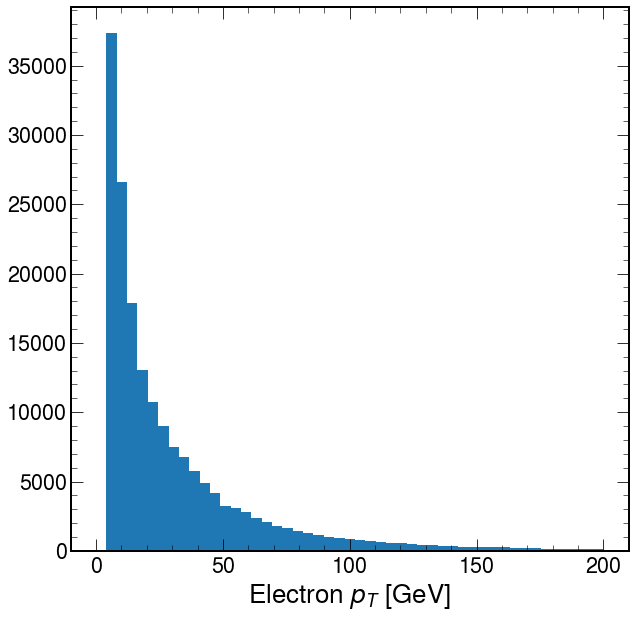

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ROOT)

fig, ax = plt.subplots()
ax.set_xlabel(r'Electron $p_{T}$ [GeV]')
ax.hist(www_events.Electron.pt.flatten(), bins=np.linspace(0, 200, 50));

Below we plot the invariant mass of all distinct pairs of electrons. The pairs are selected using the `choose` function. The `i0` and `i1` notation can be used to access the first and second electron in the pair.

In [188]:
www_events.Electron.cutBased.__doc__
www_events.Muon.mediumId.__doc__
www_events.Muon.miniIsoId.__doc__
ttbar_events.Muon.pfRelIso03_all.__doc__



'PF relative isolation dR=0.3, total (deltaBeta corrections)'

In [186]:
print(www_events.Electron.pfRelIso03_all[2] )
electron_cut = www_events.Electron.pfRelIso03_all < 0.3

print( electron_cut[2])
print( www_events.Electron.pfRelIso03_all  )
print( www_events.Electron[electron_cut].pfRelIso03_all  )

[0.0053323]
[ True]
[[0.0 4.3208194] [] [0.0053322953] ... [] [] []]
[[0.0] [] [0.0053322953] ... [] [] []]


In [191]:
def electron_cut(el):
    # medium ID has some isolation applied
    return el[ ( el.pt > 25 ) & ( abs(el.eta) < 2.5 ) & (el.cutBased >= el.MEDIUM) & (el.pfRelIso03_all < 0.3 )  ] 

def muon_cut(mu):
    return mu[ ( mu.pt > 25 ) & ( abs(mu.eta) < 2.5 ) & (mu.mediumId == True) & (mu.pfRelIso03_all < 0.3) ]

def n_electron_cut(evt):
    return evt[ electron_cut(evt.Electron).counts > 0 ]

def n_muon_cut(evt):
    return evt[ muon_cut(evt.Muon).counts > 0 ]

def n_lepton_cut(evt):
    return evt[ electron_cut(evt.Electron).counts + muon_cut(evt.Muon).counts > 0 ] 

In [192]:


# learning
#evt = 2
#print ( "Electron pT in event : ", www_events.Electron.pt[evt])
#print ( "Electron pT cut mask in event : ", electron_pt_cut[evt])
#print ( "Electrons passing pT in event :", www_events.Electron[electron_pt_cut][evt] )
#print ( "N electrons passing pT cut in event: ", www_events[n_electron_cut][evt] )
#

#n_electron_cut = electron_cut(www_events.Electron).counts > 0
#n_muon_cut     = muon_cut(www_events.Muon).counts > 0
#n_lepton_cut = electron_cut(www_events.Electron).counts + muon_cut(www_events.Muon).counts > 0
#
print( "WWW events" )   
print( len(www_events))
print( "At least one el  : ", len(n_electron_cut( www_events)  ) ) 
print( "At least one mu  : ", len(n_muon_cut( www_events)  ) )
print( "At least one lep : ", len(n_lepton_cut( www_events)  ) )



print( "TTBAR events" )   
print( len(ttbar_events))
print( "At least one el  : ", len(n_electron_cut( ttbar_events)  ) ) 
print( "At least one mu  : ", len(n_muon_cut( ttbar_events)  ) )
print( "At least one lep : ", len(n_lepton_cut( ttbar_events)  ) )


WWW events
192353
At least one el  :  33195
At least one mu  :  39625
At least one lep :  67713
TTBAR events
932840
At least one el  :  118143
At least one mu  :  149497
At least one lep :  256600


In [207]:
ttbar_events.FatJet.columns


['area',
 'btagCMVA',
 'btagCSVV2',
 'btagDeepB',
 'btagHbb',
 'eta',
 'mass',
 'msoftdrop',
 'n2b1',
 'n3b1',
 'phi',
 'pt',
 'tau1',
 'tau2',
 'tau3',
 'tau4',
 'jetId',
 'subjets']

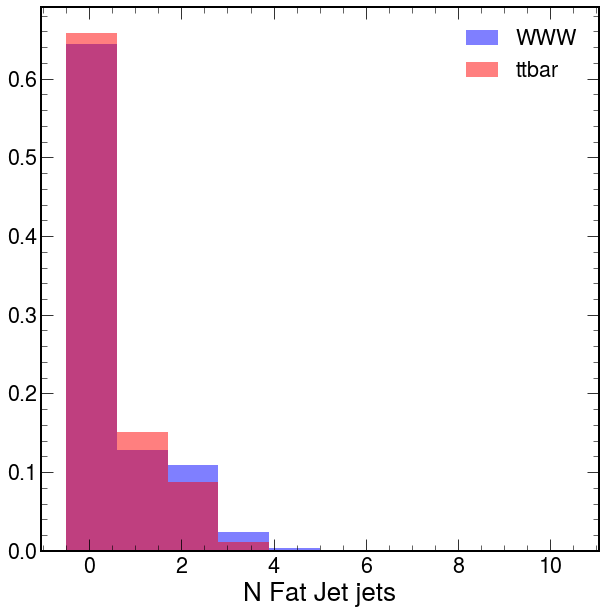

In [201]:
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(-0.5,10.5,11),
    'density': True,
}
#plt.style.use(mplhep.style.ROOT)

fig, ax = plt.subplots()
ax.set_xlabel(r'N Fat Jet jets')
ax.hist(www_events.FatJet.counts.flatten(), color='blue', label='WWW', **common_opts)
ax.hist(ttbar_events.FatJet.counts.flatten(), color='red', label='ttbar', **common_opts)
ax.legend()

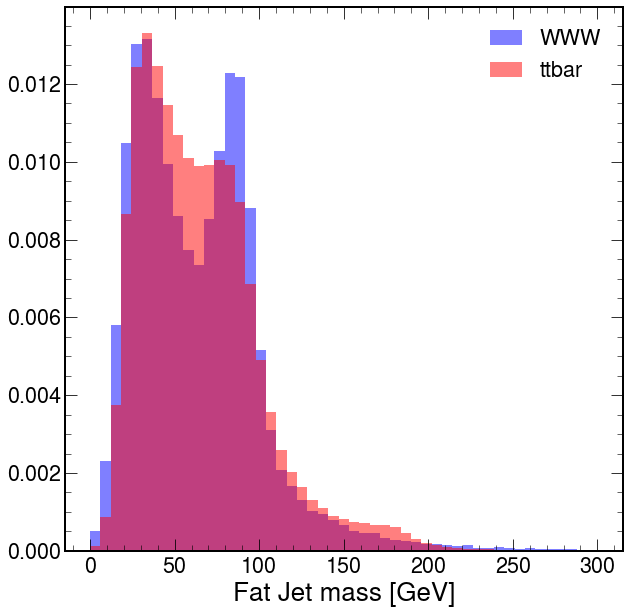

In [205]:
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0,300,50),
    'density': True,
}
#plt.style.use(mplhep.style.ROOT)

fig, ax = plt.subplots()
ax.set_xlabel(r'Fat Jet mass [GeV]')
ax.hist(www_events.FatJet.mass.flatten(), color='blue', label='WWW', **common_opts)
ax.hist(ttbar_events.FatJet.mass.flatten(), color='red', label='ttbar', **common_opts)
ax.legend()

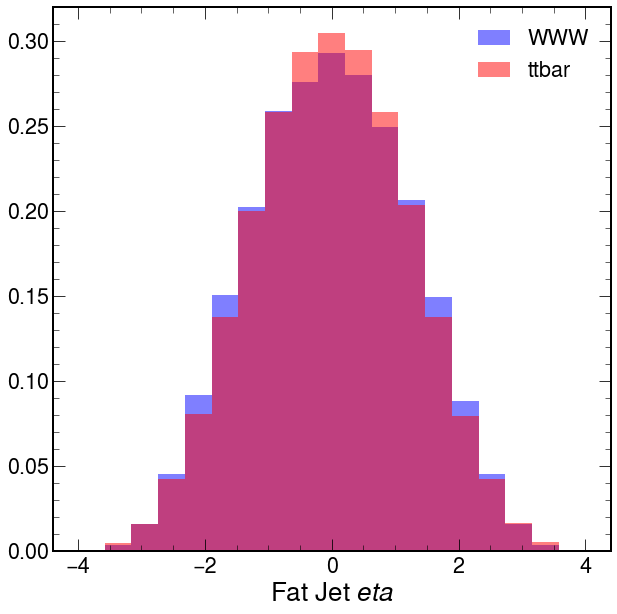

In [209]:
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(-4,4,20),
    'density': True,
}
#plt.style.use(mplhep.style.ROOT)

fig, ax = plt.subplots()
ax.set_xlabel(r'Fat Jet $eta$')
ax.hist(www_events.FatJet.eta.flatten(), color='blue', label='WWW', **common_opts)
ax.hist(ttbar_events.FatJet.eta.flatten(), color='red', label='ttbar', **common_opts)
ax.legend()

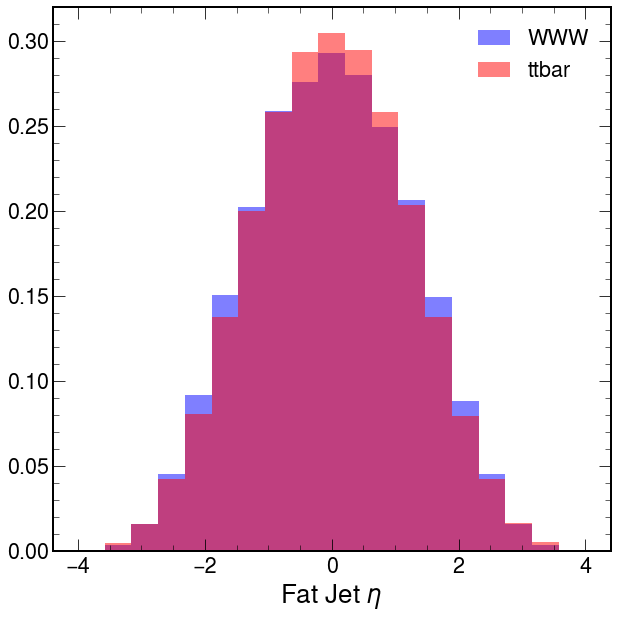

In [210]:
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(-4,4,20),
    'density': True,
}
#plt.style.use(mplhep.style.ROOT)

fig, ax = plt.subplots()
ax.set_xlabel(r'Fat Jet $\eta$')
ax.hist(www_events.FatJet.eta.flatten(), color='blue', label='WWW', **common_opts)
ax.hist(ttbar_events.FatJet.eta.flatten(), color='red', label='ttbar', **common_opts)
ax.legend()

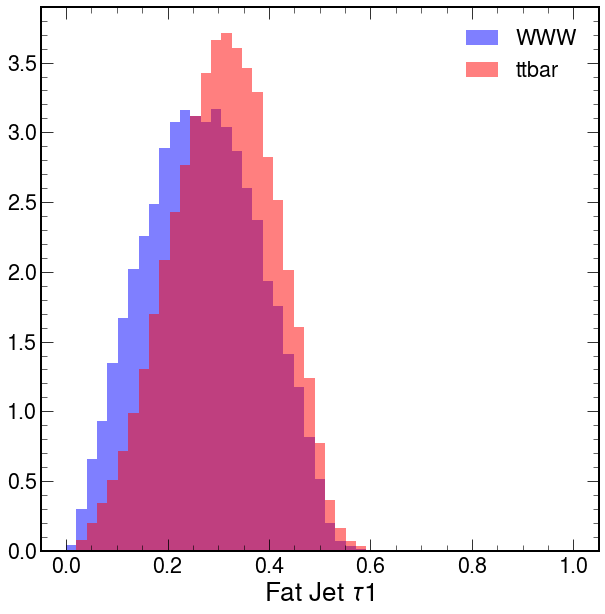

In [217]:
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0,1,50),
    'density': True,
}
#plt.style.use(mplhep.style.ROOT)

www_fatjets = www_events.FatJet
ttb_fatjets = ttbar_events.FatJet

def mass_cut(jets): 
   return jets [ (jets.mass > 60) & (jets.mass < 100) ]

fig, ax = plt.subplots()
ax.set_xlabel(r'Fat Jet $\tau 1$')
ax.hist(mass_cut(www_fatjets).tau1.flatten(), color='blue', label='WWW', **common_opts)
ax.hist(mass_cut(ttb_fatjets).tau1.flatten(), color='red', label='ttbar', **common_opts)
ax.legend()

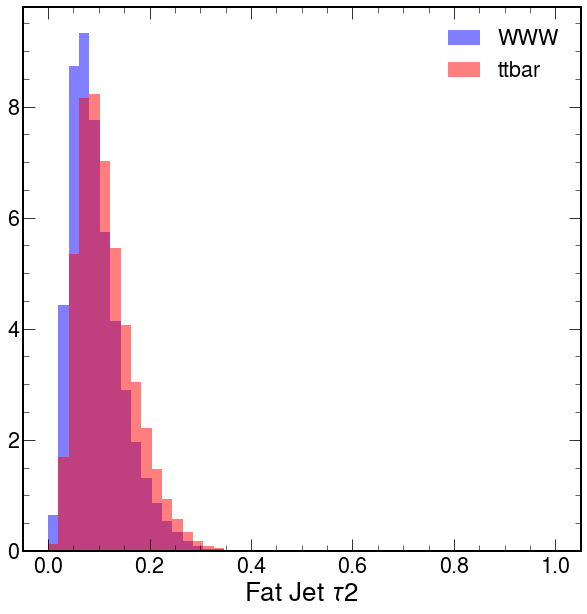

In [218]:
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0,1,50),
    'density': True,
}
#plt.style.use(mplhep.style.ROOT)

www_fatjets = www_events.FatJet
ttb_fatjets = ttbar_events.FatJet

def mass_cut(jets): 
   return jets [ (jets.mass > 60) & (jets.mass < 100) ]

fig, ax = plt.subplots()
ax.set_xlabel(r'Fat Jet $\tau 2$')
ax.hist(mass_cut(www_fatjets).tau2.flatten(), color='blue', label='WWW', **common_opts)
ax.hist(mass_cut(ttb_fatjets).tau2.flatten(), color='red', label='ttbar', **common_opts)
ax.legend()